# 🥖 Too Good To Go - Agent-Based Microeconomic Model

This notebook implements a microeconomic agent-based simulation to investigate the effects of food waste reduction services (like **Too Good To Go**) on:
- **Total production** of goods
- **Total food waste**

We use **evolutionary algorithms** to optimize the baker's production strategy based on a risk-adjusted utility function.

---

## Table of Contents
1. [Setup & Imports](#setup)
2. [Configuration & Parameters](#config)
3. [Core Classes](#classes)
4. [Simulation Logic](#simulation)
5. [Evolutionary Algorithm](#evolution)
6. [Running the Experiment](#experiment)
7. [Results & Analysis](#results)

<a id="setup"></a>
## 1. Setup & Imports

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from dataclasses import dataclass, field
from typing import List, Tuple, Optional
from copy import deepcopy
from tqdm import tqdm  # Use standard tqdm instead of tqdm.notebook
import warnings

# Configuration
np.random.seed(42)
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("✅ All imports successful!")

✅ All imports successful!


<a id="config"></a>
## 2. Configuration & Parameters

We define all the model parameters as described in the specification:
- **Environment parameters**: market characteristics
- **Evolution hyperparameters**: training configuration

In [30]:
@dataclass
class EnvironmentConfig:
    """
    Environment parameters for the bakery simulation.
    
    Key economics:
    - Expected visitors per day: N * alpha
    - Each visitor buys at most 1 unit
    - Optimal production ≈ N * alpha (match expected demand)
    
    TGTG trade-off:
    - Regular sale profit: rho - chi
    - TGTG profit: tau - chi (lower but guaranteed)
    - Waste loss: -chi (production cost lost)
    """
    N: int = 80                 # Number of consumers
    L: int = 3                  # Number of different goods (will vary in experiments)
    r: float = 0.25             # Walk-out probability (lower = more patient)
    chi: float = 1.0            # Production cost per unit
    rho: float = 4.0            # Sale price per unit (high margin: 3x cost)
    tau: float = 1.5            # TGTG price per unit (small profit: 0.5 above cost)
    alpha: float = 0.7          # Probability of visiting (higher for more predictable demand)
    
    def __post_init__(self):
        assert self.rho > self.chi, f"Sale price (ρ={self.rho}) must be > production cost (χ={self.chi})"
        assert self.tau > self.chi, f"TGTG price (τ={self.tau}) must be > production cost (χ={self.chi}) for profit"
        assert self.tau < self.rho, f"TGTG price (τ={self.tau}) must be < sale price (ρ={self.rho})"
        assert 0 <= self.r <= 1, f"Walk-out probability must be in [0,1], got {self.r}"
        assert 0 <= self.alpha <= 1, f"Visit probability must be in [0,1], got {self.alpha}"
    
    @property
    def expected_demand(self) -> float:
        """Expected number of visitors per day."""
        return self.N * self.alpha
    
    @property
    def regular_margin(self) -> float:
        return self.rho - self.chi
    
    @property
    def tgtg_margin(self) -> float:
        return self.tau - self.chi


@dataclass
class EvolutionConfig:
    """
    Hyperparameters for the evolutionary algorithm.
    """
    mu: float = 0.5             # Mutation probability (high for exploration)
    sigma_q: float = 3.0        # Mutation std for quantities
    sigma_b: float = 0.10       # Mutation std for bag share
    D: int = 40                 # Days per epoch
    E: int = 60                 # Number of generations
    population_size: int = 80   # Population size
    elite_fraction: float = 0.15 # Top 15% selected as parents


# Create default configurations
env_config = EnvironmentConfig()
evo_config = EvolutionConfig()

# Display configurations as tables
print("=" * 70)
print("ENVIRONMENT CONFIGURATION")
print("=" * 70)
env_df = pd.DataFrame([
    ("N", "Number of consumers", env_config.N),
    ("L", "Number of goods", env_config.L),
    ("r", "Walk-out probability", f"{env_config.r:.0%}"),
    ("χ", "Production cost", f"${env_config.chi:.2f}"),
    ("ρ", "Sale price", f"${env_config.rho:.2f}"),
    ("τ", "TGTG price", f"${env_config.tau:.2f}"),
    ("α", "Visit probability", f"{env_config.alpha:.0%}"),
], columns=["Symbol", "Description", "Value"])
print(env_df.to_string(index=False))

print("\n" + "=" * 70)
print("ECONOMIC ANALYSIS")
print("=" * 70)
print(f"Expected daily visitors: {env_config.expected_demand:.0f}")
print(f"Regular sale margin: ρ - χ = ${env_config.regular_margin:.2f} per unit")
print(f"TGTG margin: τ - χ = ${env_config.tgtg_margin:.2f} per unit")
print(f"Waste loss: -χ = ${-env_config.chi:.2f} per unit")
print(f"\nMargin comparison:")
print(f"  • Regular sale is {env_config.regular_margin / env_config.tgtg_margin:.1f}x more profitable than TGTG")
print(f"  • TGTG recovers {env_config.tau / env_config.chi:.1f}x the production cost (vs 0x for waste)")

print("\n" + "=" * 70)
print("EVOLUTION CONFIGURATION")
print("=" * 70)
evo_df = pd.DataFrame([
    ("μ", "Mutation probability", f"{evo_config.mu:.0%}"),
    ("σ_q", "Quantity mutation std", evo_config.sigma_q),
    ("σ_b", "Bag share mutation std", evo_config.sigma_b),
    ("D", "Days per epoch", evo_config.D),
    ("E", "Generations", evo_config.E),
    ("Pop", "Population size", evo_config.population_size),
    ("Elite", "Elite fraction", f"{evo_config.elite_fraction:.0%}"),
], columns=["Symbol", "Description", "Value"])
print(evo_df.to_string(index=False))

ENVIRONMENT CONFIGURATION
Symbol          Description Value
     N  Number of consumers    80
     L      Number of goods     3
     r Walk-out probability   25%
     χ      Production cost $1.00
     ρ           Sale price $4.00
     τ           TGTG price $1.50
     α    Visit probability   70%

ECONOMIC ANALYSIS
Expected daily visitors: 56
Regular sale margin: ρ - χ = $3.00 per unit
TGTG margin: τ - χ = $0.50 per unit
Waste loss: -χ = $-1.00 per unit

Margin comparison:
  • Regular sale is 6.0x more profitable than TGTG
  • TGTG recovers 1.5x the production cost (vs 0x for waste)

EVOLUTION CONFIGURATION
Symbol            Description Value
     μ   Mutation probability   50%
   σ_q  Quantity mutation std   3.0
   σ_b Bag share mutation std   0.1
     D         Days per epoch    40
     E            Generations    60
   Pop        Population size    80
 Elite         Elite fraction   15%


<a id="classes"></a>
## 3. Core Classes

### 3.1 Consumer Class
Each consumer has fixed preferences and stochastic visiting behavior.

Creating consumer population...
✅ Created 80 consumers with 3 goods


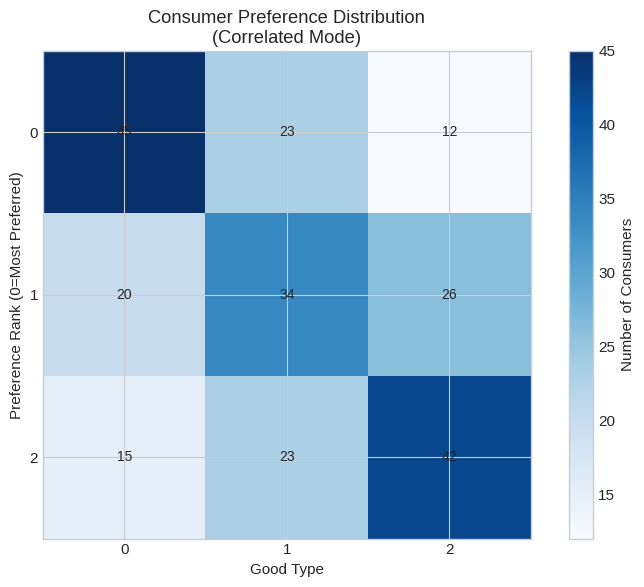

In [31]:
class Consumer:
    """
    A consumer with fixed preferences over goods.
    
    Each consumer has a preference ordering over all L goods.
    When visiting the store, they try to buy their most preferred
    available good, walking out with probability r if unavailable.
    """
    
    def __init__(self, preferences: np.ndarray):
        """
        Args:
            preferences: Array of shape (L,) with goods ordered by preference
                         (index 0 = most preferred)
        """
        self.preferences = preferences
    
    def decides_to_visit(self, alpha: float) -> bool:
        """Bernoulli draw to decide whether to visit the store today."""
        return np.random.random() < alpha
    
    def attempt_purchase(self, inventory: np.ndarray, r: float) -> Tuple[int, bool]:
        """
        Attempt to purchase a good from the store.
        
        Args:
            inventory: Current available inventory for each good
            r: Walk-out probability when preferred good is unavailable
            
        Returns:
            Tuple of (good_index, success). If success=False, good_index=-1.
        """
        for good in self.preferences:
            if inventory[good] > 0:
                # Found preferred good, purchase it
                return (good, True)
            else:
                # Good not available, might walk out
                if np.random.random() < r:
                    return (-1, False)  # Walk out
                # Otherwise, continue to next preference
        
        # Exhausted all preferences without finding anything
        return (-1, False)


class ConsumerPopulation:
    """
    Population of N consumers with heterogeneous preferences.
    """
    
    def __init__(self, N: int, L: int, preference_mode: str = "random"):
        """
        Args:
            N: Number of consumers
            L: Number of different goods
            preference_mode: How to generate preferences
                - "random": Each consumer gets a random permutation
                - "correlated": Some goods are generally more popular
        """
        self.N = N
        self.L = L
        self.consumers = []
        
        if preference_mode == "random":
            # Each consumer has a random preference ordering
            for _ in range(N):
                prefs = np.random.permutation(L)
                self.consumers.append(Consumer(prefs))
        elif preference_mode == "correlated":
            # Goods have different base popularity
            # Good 0 is most popular, good L-1 is least popular
            for _ in range(N):
                # Use Plackett-Luce style sampling
                weights = np.exp(-np.arange(L) * 0.5)  # Exponential decay
                prefs = []
                remaining = list(range(L))
                for _ in range(L):
                    w = weights[remaining] / weights[remaining].sum()
                    choice = np.random.choice(remaining, p=w)
                    prefs.append(choice)
                    remaining.remove(choice)
                self.consumers.append(Consumer(np.array(prefs)))
        else:
            raise ValueError(f"Unknown preference_mode: {preference_mode}")
    
    def get_visiting_consumers(self, alpha: float) -> List[Consumer]:
        """Return list of consumers who decide to visit today."""
        visitors = [c for c in self.consumers if c.decides_to_visit(alpha)]
        np.random.shuffle(visitors)  # Random arrival order
        return visitors


# Test consumer population
print("Creating consumer population...")
test_consumers = ConsumerPopulation(N=env_config.N, L=env_config.L, preference_mode="correlated")
print(f"✅ Created {len(test_consumers.consumers)} consumers with {env_config.L} goods")

# Show preference distribution
pref_counts = np.zeros((env_config.L, env_config.L))
for c in test_consumers.consumers:
    for rank, good in enumerate(c.preferences):
        pref_counts[rank, good] += 1

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(pref_counts, cmap='Blues')
ax.set_xlabel('Good Type')
ax.set_ylabel('Preference Rank (0=Most Preferred)')
ax.set_title('Consumer Preference Distribution\n(Correlated Mode)')
ax.set_xticks(range(env_config.L))
ax.set_yticks(range(env_config.L))
plt.colorbar(im, label='Number of Consumers')
for i in range(env_config.L):
    for j in range(env_config.L):
        ax.text(j, i, int(pref_counts[i, j]), ha='center', va='center', fontsize=10)
plt.tight_layout()
plt.show()

### 3.2 Baker Agent Class
The baker agent has trainable parameters (q, b) and a fixed risk aversion factor (γ).

In [32]:
@dataclass
class BakerAgent:
    """
    The baker agent that decides production quantities and TGTG allocation.
    
    Trainable parameters:
        q: Vector of quantities to produce for each good (shape: L)
        b: Share of production reserved for TGTG bags [0, 1]
    
    Fixed parameter:
        gamma: Risk aversion factor
               - gamma < 0: Risk-seeking (prefers variance)
               - gamma = 0: Risk-neutral (only cares about expected profit)
               - gamma > 0: Risk-averse (penalizes variance)
    """
    q: np.ndarray           # Production quantities per good
    b: float                # TGTG bag share
    gamma: float            # Risk aversion factor
    fitness: float = 0.0    # Fitness score (set after evaluation)
    
    def total_production(self) -> int:
        """Total units produced: ||q||_1"""
        return int(np.sum(self.q))
    
    def tgtg_units(self) -> int:
        """Number of units reserved for TGTG bags."""
        return int(np.floor(self.b * self.total_production()))
    
    def clone(self) -> 'BakerAgent':
        """Create a deep copy of this agent."""
        return BakerAgent(
            q=self.q.copy(),
            b=self.b,
            gamma=self.gamma,
            fitness=0.0
        )
    
    def mutate(self, mu: float, sigma_q: float, sigma_b: float) -> 'BakerAgent':
        """
        Create a mutated copy of this agent.
        """
        new_q = self.q.copy().astype(float)
        new_b = self.b
        
        # Mutate each quantity independently
        for i in range(len(new_q)):
            if np.random.random() < mu:
                new_q[i] += np.random.normal(0, sigma_q)
                new_q[i] = max(1, round(new_q[i]))  # At least 1 unit
        
        # Mutate bag share - NO ARTIFICIAL UPPER LIMIT
        if np.random.random() < mu:
            new_b += np.random.normal(0, sigma_b)
            new_b = np.clip(new_b, 0.0, 1.0)  # Natural bounds [0, 1]
        
        return BakerAgent(
            q=new_q.astype(int),
            b=new_b,
            gamma=self.gamma,
            fitness=0.0
        )
    
    def __repr__(self):
        return f"BakerAgent(q={self.q}, b={self.b:.3f}, γ={self.gamma:.2f}, fitness={self.fitness:.2f})"


def create_random_agent(L: int, gamma: float, expected_demand: float) -> BakerAgent:
    """
    Create a random agent with production scaled to expected demand.
    
    Args:
        L: Number of goods
        gamma: Risk aversion factor
        expected_demand: Expected visitors per day (for scaling)
    """
    # Production per good: distribute expected demand across goods with some noise
    base_per_good = expected_demand / L
    q = np.array([max(3, int(base_per_good * np.random.uniform(0.5, 1.5))) for _ in range(L)])
    
    # TGTG share - uniform distribution to explore full range
    b = np.random.uniform(0.0, 0.6)
    
    return BakerAgent(q=q, b=b, gamma=gamma)


def create_population(size: int, L: int, gamma: float, expected_demand: float) -> List[BakerAgent]:
    """Create a population of random agents with diverse strategies."""
    population = []
    for i in range(size):
        agent = create_random_agent(L, gamma, expected_demand)
        population.append(agent)
    return population


# Test agent creation
test_agent = create_random_agent(L=env_config.L, gamma=0.5, expected_demand=env_config.expected_demand)
print(f"Expected demand: {env_config.expected_demand:.0f} visitors/day")
print(f"Test agent: {test_agent}")
print(f"  Total production: {test_agent.total_production()} units")
print(f"  TGTG reserved: {test_agent.tgtg_units()} units ({test_agent.b:.1%})")

# Test mutation
mutated = test_agent.mutate(mu=0.5, sigma_q=5, sigma_b=0.1)
print(f"\nMutated agent: {mutated}")

# Show initial population diversity
print("\n" + "=" * 60)
print("INITIAL POPULATION DIVERSITY (sample of 10 agents)")
print("=" * 60)
sample_pop = create_population(10, env_config.L, gamma=0.5, expected_demand=env_config.expected_demand)
for i, agent in enumerate(sample_pop):
    print(f"  Agent {i+1}: q={agent.q}, total={agent.total_production()}, b={agent.b:.1%}")

Expected demand: 56 visitors/day
Test agent: BakerAgent(q=[26 27 26], b=0.222, γ=0.50, fitness=0.00)
  Total production: 79 units
  TGTG reserved: 17 units (22.2%)

Mutated agent: BakerAgent(q=[25 27 26], b=0.222, γ=0.50, fitness=0.00)

INITIAL POPULATION DIVERSITY (sample of 10 agents)
  Agent 1: q=[14 16 25], total=55, b=19.0%
  Agent 2: q=[12 19 26], total=57, b=41.8%
  Agent 3: q=[19 11 20], total=50, b=59.4%
  Agent 4: q=[11 19 25], total=55, b=44.4%
  Agent 5: q=[22 22 16], total=60, b=17.6%
  Agent 6: q=[24 24 25], total=73, b=54.8%
  Agent 7: q=[18 18 24], total=60, b=39.0%
  Agent 8: q=[22 24 25], total=71, b=20.3%
  Agent 9: q=[16 11 20], total=47, b=2.2%
  Agent 10: q=[18 19 14], total=51, b=35.4%


<a id="simulation"></a>
## 4. Simulation Logic

### 4.1 Daily Simulation
Each day, consumers visit the bakery and attempt to purchase goods based on their preferences.

In [33]:
@dataclass
class DayResult:
    """Results from a single day simulation."""
    regular_sales: int      # Units sold at regular price
    tgtg_sales: int         # Units sold as TGTG bags
    waste: int              # Units wasted (unsold, not TGTG)
    visitors: int           # Number of consumers who visited
    walkouts: int           # Number of consumers who left without buying
    profit: float           # Daily profit


def simulate_day(
    agent: BakerAgent,
    consumers: ConsumerPopulation,
    env: EnvironmentConfig
) -> DayResult:
    """
    Simulate a single day of bakery operation.
    
    The simulation proceeds as follows:
    1. Baker produces q units of each good
    2. Baker reserves floor(b * total) units for TGTG
    3. Consumers arrive randomly and attempt to purchase
    4. Shop closes for REGULAR sales when remaining inventory = reserved TGTG units
    5. TGTG bags are ALWAYS sold at end of day (guaranteed revenue)
    6. Any remaining inventory (beyond TGTG) is waste
    
    Key insight: TGTG provides GUARANTEED sales, reducing uncertainty.
    Regular sales are uncertain (depend on demand realization).
    
    Args:
        agent: The baker agent with production decisions
        consumers: Population of consumers
        env: Environment configuration
        
    Returns:
        DayResult with all metrics
    """
    # Initialize inventory
    inventory = agent.q.copy().astype(float)
    total_produced = agent.total_production()
    tgtg_reserved = agent.tgtg_units()
    
    # Track metrics
    regular_sales = 0
    walkouts = 0
    
    # Get today's visitors (stochastic!)
    visitors = consumers.get_visiting_consumers(env.alpha)
    
    # Process each visitor
    for consumer in visitors:
        # Check if shop is still open for regular sales
        # Must keep TGTG reserved units unavailable for regular purchase
        current_inventory = int(np.sum(inventory))
        available_for_regular = current_inventory - tgtg_reserved
        
        if available_for_regular <= 0:
            # Shop closed for regular sales, visitor can't buy
            walkouts += 1
            continue
        
        # Consumer attempts to purchase
        # Only consider goods with positive inventory ABOVE the threshold
        temp_inventory = inventory.copy()
        # Proportionally reduce available inventory to account for TGTG reserve
        if current_inventory > 0:
            scale = available_for_regular / current_inventory
            temp_inventory = np.floor(inventory * scale)
        
        good_idx, success = consumer.attempt_purchase(inventory, env.r)
        
        if success and inventory[good_idx] > 0:
            inventory[good_idx] -= 1
            regular_sales += 1
        else:
            walkouts += 1
    
    # End of day calculations
    remaining_inventory = int(np.sum(inventory))
    
    # TGTG bags: minimum of reserved and what's actually left
    tgtg_sales = min(tgtg_reserved, remaining_inventory)
    
    # Waste is anything left over beyond what TGTG can absorb
    waste = max(0, remaining_inventory - tgtg_sales)
    
    # Calculate profit
    # Revenue: regular sales at ρ, TGTG at τ
    # Cost: all production at χ
    # Note: waste items were produced (cost χ) but not sold (revenue 0)
    revenue = regular_sales * env.rho + tgtg_sales * env.tau
    cost = total_produced * env.chi
    profit = revenue - cost
    
    return DayResult(
        regular_sales=regular_sales,
        tgtg_sales=tgtg_sales,
        waste=waste,
        visitors=len(visitors),
        walkouts=walkouts,
        profit=profit
    )


# Test single day simulation
print("Testing single day simulation...")
print(f"Agent: q={test_agent.q}, b={test_agent.b:.1%}")
test_result = simulate_day(test_agent, test_consumers, env_config)
print(f"\nDay Result:")
print(f"  Visitors: {test_result.visitors}")
print(f"  Regular sales: {test_result.regular_sales} (revenue: ${test_result.regular_sales * env_config.rho:.2f})")
print(f"  TGTG sales: {test_result.tgtg_sales} (revenue: ${test_result.tgtg_sales * env_config.tau:.2f})")
print(f"  Walkouts: {test_result.walkouts}")
print(f"  Waste: {test_result.waste} (lost cost: ${test_result.waste * env_config.chi:.2f})")
print(f"  Total production cost: ${test_agent.total_production() * env_config.chi:.2f}")
print(f"  Profit: ${test_result.profit:.2f}")

Testing single day simulation...
Agent: q=[26 27 26], b=22.2%

Day Result:
  Visitors: 62
  Regular sales: 60 (revenue: $240.00)
  TGTG sales: 17 (revenue: $25.50)
  Walkouts: 2
  Waste: 2 (lost cost: $2.00)
  Total production cost: $79.00
  Profit: $186.50


### 4.2 Epoch Simulation & Fitness Calculation

An epoch consists of D days. The agent's fitness is calculated using the risk-adjusted reward:

$$R_\gamma = \pi - \frac{\gamma}{2} \cdot \sigma^2$$

where $\pi$ is total profit and $\sigma^2$ is the variance of daily profits.

Testing epoch simulation (40 days)...

Epoch Result:
  Total Production: 3160 units
  Total Regular Sales: 2194
  Total TGTG Sales: 680
  Total Waste: 286
  Mean Daily Profit: $165.90
  Profit Std Dev: $12.31
  Coefficient of Variation: 7.4%
  Fitness (γ=0.5): 6389.72
  Avg Daily Visitors: 56.8
  Avg Daily Walkouts: 1.9


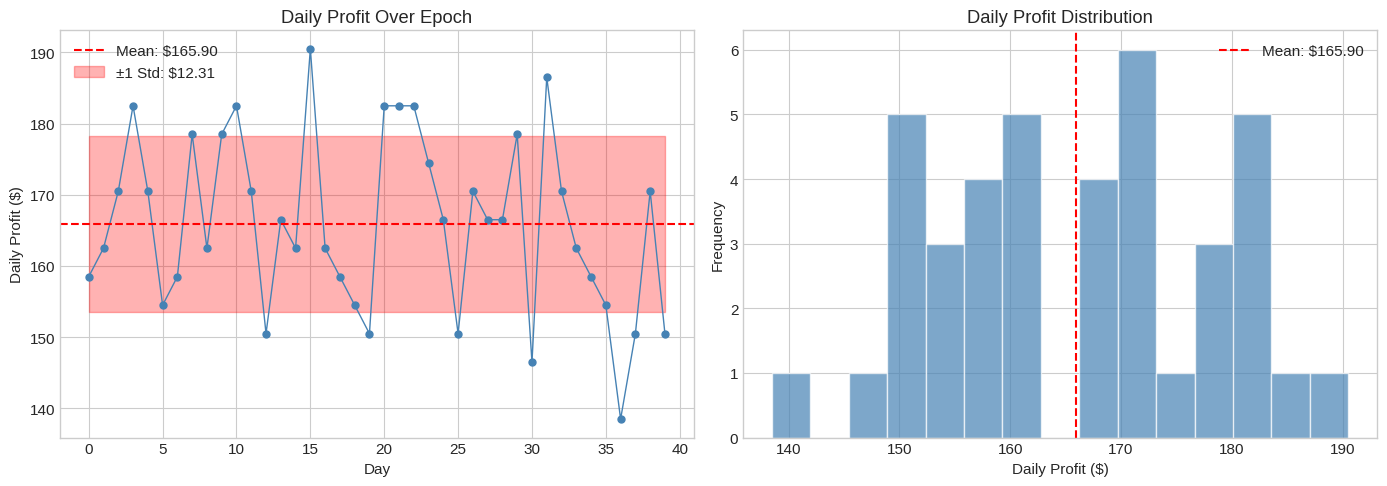


RISK AVERSION EFFECT ON FITNESS (same profit distribution)
γ = -1.0: fitness = 7128.6 (risk penalty: -492.6)
γ = +0.0: fitness = 6636.0 (risk penalty: +0.0)
γ = +0.5: fitness = 6389.7 (risk penalty: +246.3)
γ = +1.0: fitness = 6143.4 (risk penalty: +492.6)
γ = +2.0: fitness = 5650.9 (risk penalty: +985.1)


In [34]:
@dataclass
class EpochResult:
    """Aggregated results from an epoch (D days)."""
    daily_profits: np.ndarray
    total_profit: float
    mean_profit: float
    profit_std: float
    profit_variance: float
    fitness: float
    total_regular_sales: int
    total_tgtg_sales: int
    total_waste: int
    total_production: int
    avg_visitors: float
    avg_walkouts: float


def simulate_epoch(
    agent: BakerAgent,
    consumers: ConsumerPopulation,
    env: EnvironmentConfig,
    D: int
) -> EpochResult:
    """
    Simulate an epoch of D days.
    
    Each day has independent demand realizations due to:
    - Stochastic consumer visit decisions
    - Random arrival order
    - Stochastic walk-out decisions
    
    Fitness formula (risk-adjusted):
        R_γ = E[π] - γ * σ(π)
    
    where:
        E[π] = mean daily profit
        σ(π) = standard deviation of daily profit
        γ = risk aversion coefficient
    
    This is a mean-variance formulation using std dev for better scaling.
    
    Args:
        agent: The baker agent
        consumers: Consumer population
        env: Environment config
        D: Number of days in the epoch
        
    Returns:
        EpochResult with aggregated metrics and fitness
    """
    daily_results = []
    
    for _ in range(D):
        result = simulate_day(agent, consumers, env)
        daily_results.append(result)
    
    # Aggregate metrics
    daily_profits = np.array([r.profit for r in daily_results])
    total_profit = np.sum(daily_profits)
    mean_profit = np.mean(daily_profits)
    profit_std = np.std(daily_profits)
    profit_variance = np.var(daily_profits)
    
    # Calculate fitness using mean-std formulation
    # R_γ = D * (mean_profit - γ * std_profit)
    # This makes the risk term comparable to the profit term
    fitness = D * (mean_profit - agent.gamma * profit_std)
    
    return EpochResult(
        daily_profits=daily_profits,
        total_profit=total_profit,
        mean_profit=mean_profit,
        profit_std=profit_std,
        profit_variance=profit_variance,
        fitness=fitness,
        total_regular_sales=sum(r.regular_sales for r in daily_results),
        total_tgtg_sales=sum(r.tgtg_sales for r in daily_results),
        total_waste=sum(r.waste for r in daily_results),
        total_production=agent.total_production() * D,
        avg_visitors=np.mean([r.visitors for r in daily_results]),
        avg_walkouts=np.mean([r.walkouts for r in daily_results])
    )


# Test epoch simulation
print(f"Testing epoch simulation ({evo_config.D} days)...")
epoch_result = simulate_epoch(test_agent, test_consumers, env_config, evo_config.D)

print(f"\nEpoch Result:")
print(f"  Total Production: {epoch_result.total_production} units")
print(f"  Total Regular Sales: {epoch_result.total_regular_sales}")
print(f"  Total TGTG Sales: {epoch_result.total_tgtg_sales}")
print(f"  Total Waste: {epoch_result.total_waste}")
print(f"  Mean Daily Profit: ${epoch_result.mean_profit:.2f}")
print(f"  Profit Std Dev: ${epoch_result.profit_std:.2f}")
print(f"  Coefficient of Variation: {epoch_result.profit_std/abs(epoch_result.mean_profit)*100:.1f}%")
print(f"  Fitness (γ={test_agent.gamma}): {epoch_result.fitness:.2f}")
print(f"  Avg Daily Visitors: {epoch_result.avg_visitors:.1f}")
print(f"  Avg Daily Walkouts: {epoch_result.avg_walkouts:.1f}")

# Visualize daily profit distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Daily profits over time
axes[0].plot(epoch_result.daily_profits, 'o-', color='steelblue', linewidth=1, markersize=5)
axes[0].axhline(y=epoch_result.mean_profit, color='red', linestyle='--', 
                label=f'Mean: ${epoch_result.mean_profit:.2f}')
axes[0].fill_between(range(len(epoch_result.daily_profits)),
                     epoch_result.mean_profit - epoch_result.profit_std,
                     epoch_result.mean_profit + epoch_result.profit_std,
                     alpha=0.3, color='red', label=f'±1 Std: ${epoch_result.profit_std:.2f}')
axes[0].set_xlabel('Day')
axes[0].set_ylabel('Daily Profit ($)')
axes[0].set_title('Daily Profit Over Epoch')
axes[0].legend()

# Profit distribution histogram
axes[1].hist(epoch_result.daily_profits, bins=15, color='steelblue', edgecolor='white', alpha=0.7)
axes[1].axvline(x=epoch_result.mean_profit, color='red', linestyle='--', 
                label=f'Mean: ${epoch_result.mean_profit:.2f}')
axes[1].set_xlabel('Daily Profit ($)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Daily Profit Distribution')
axes[1].legend()

plt.tight_layout()
plt.show()

# Show how fitness changes with different gamma values
print("\n" + "=" * 60)
print("RISK AVERSION EFFECT ON FITNESS (same profit distribution)")
print("=" * 60)
for gamma_test in [-1.0, 0.0, 0.5, 1.0, 2.0]:
    test_fitness = evo_config.D * (epoch_result.mean_profit - gamma_test * epoch_result.profit_std)
    penalty = evo_config.D * gamma_test * epoch_result.profit_std
    print(f"γ = {gamma_test:+.1f}: fitness = {test_fitness:.1f} (risk penalty: {penalty:+.1f})")

<a id="evolution"></a>
## 5. Evolutionary Algorithm

The evolution proceeds as follows:
1. Initialize population of agents
2. Evaluate each agent's fitness over an epoch
3. Select top 10% as parents (elite selection)
4. Create new generation through cloning + mutation
5. Repeat for E generations

In [35]:
@dataclass
class GenerationStats:
    """Statistics for a generation."""
    generation: int
    best_fitness: float
    mean_fitness: float
    std_fitness: float
    best_agent: BakerAgent
    best_q: np.ndarray
    best_b: float
    mean_production: float
    mean_waste: float
    mean_tgtg: float


class EvolutionaryTrainer:
    """
    Evolutionary algorithm trainer for baker agents.
    """
    
    def __init__(
        self,
        env_config: EnvironmentConfig,
        evo_config: EvolutionConfig,
        gamma: float = 0.5,
        preference_mode: str = "correlated"
    ):
        self.env = env_config
        self.evo = evo_config
        self.gamma = gamma
        self.preference_mode = preference_mode
        
        # Initialize consumers (fixed for all training)
        self.consumers = ConsumerPopulation(
            N=env_config.N,
            L=env_config.L,
            preference_mode=preference_mode
        )
        
        # Initialize population with proper scaling
        self.population = create_population(
            size=evo_config.population_size,
            L=env_config.L,
            gamma=gamma,
            expected_demand=env_config.expected_demand  # Pass expected demand
        )
        
        # Training history
        self.history: List[GenerationStats] = []
        self.all_epoch_results: List[List[EpochResult]] = []
        
    def evaluate_population(self) -> List[EpochResult]:
        """Evaluate fitness of all agents in the population."""
        results = []
        for agent in self.population:
            epoch_result = simulate_epoch(
                agent, self.consumers, self.env, self.evo.D
            )
            agent.fitness = epoch_result.fitness
            results.append(epoch_result)
        return results
    
    def select_parents(self) -> List[BakerAgent]:
        """Select top performers as parents."""
        n_parents = max(1, int(self.evo.elite_fraction * len(self.population)))
        sorted_pop = sorted(self.population, key=lambda a: a.fitness, reverse=True)
        return sorted_pop[:n_parents]
    
    def create_next_generation(self, parents: List[BakerAgent]) -> List[BakerAgent]:
        """Create new generation through cloning and mutation."""
        new_pop = []
        
        # Keep best parent unchanged (elitism)
        new_pop.append(parents[0].clone())
        
        # Fill remaining slots with mutated offspring
        while len(new_pop) < self.evo.population_size:
            parent = np.random.choice(parents)
            offspring = parent.mutate(
                mu=self.evo.mu,
                sigma_q=self.evo.sigma_q,
                sigma_b=self.evo.sigma_b
            )
            new_pop.append(offspring)
        
        return new_pop
    
    def train(self, verbose: bool = True) -> List[GenerationStats]:
        """
        Run the evolutionary training loop.
        
        Args:
            verbose: Whether to show progress bar
            
        Returns:
            List of generation statistics
        """
        iterator = range(self.evo.E)
        if verbose:
            iterator = tqdm(iterator, desc="Evolution Progress")
        
        for gen in iterator:
            # Evaluate population
            epoch_results = self.evaluate_population()
            self.all_epoch_results.append(epoch_results)
            
            # Calculate statistics
            fitnesses = [a.fitness for a in self.population]
            best_idx = np.argmax(fitnesses)
            best_agent = self.population[best_idx]
            best_result = epoch_results[best_idx]
            
            # Calculate mean metrics
            mean_production = np.mean([r.total_production for r in epoch_results])
            mean_waste = np.mean([r.total_waste for r in epoch_results])
            mean_tgtg = np.mean([r.total_tgtg_sales for r in epoch_results])
            
            stats = GenerationStats(
                generation=gen,
                best_fitness=best_agent.fitness,
                mean_fitness=np.mean(fitnesses),
                std_fitness=np.std(fitnesses),
                best_agent=best_agent.clone(),
                best_q=best_agent.q.copy(),
                best_b=best_agent.b,
                mean_production=mean_production,
                mean_waste=mean_waste,
                mean_tgtg=mean_tgtg
            )
            self.history.append(stats)
            
            # Update progress bar
            if verbose and hasattr(iterator, 'set_postfix'):
                iterator.set_postfix({
                    'best': f'{best_agent.fitness:.1f}',
                    'mean': f'{np.mean(fitnesses):.1f}'
                })
            
            # Create next generation (unless last generation)
            if gen < self.evo.E - 1:
                parents = self.select_parents()
                self.population = self.create_next_generation(parents)
        
        return self.history
    
    def get_best_agent(self) -> BakerAgent:
        """Return the best agent from the final generation."""
        return max(self.population, key=lambda a: a.fitness)
    
    def plot_training_progress(self):
        """Plot training curves."""
        generations = [s.generation for s in self.history]
        
        fig, axes = plt.subplots(2, 3, figsize=(16, 10))
        
        # Fitness over time
        ax = axes[0, 0]
        ax.plot(generations, [s.best_fitness for s in self.history], 
                'b-', linewidth=2, label='Best')
        ax.plot(generations, [s.mean_fitness for s in self.history], 
                'g--', linewidth=1.5, label='Mean')
        ax.fill_between(generations,
                        [s.mean_fitness - s.std_fitness for s in self.history],
                        [s.mean_fitness + s.std_fitness for s in self.history],
                        alpha=0.2, color='green')
        ax.set_xlabel('Generation')
        ax.set_ylabel('Fitness')
        ax.set_title('Fitness Evolution')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Production quantities over time
        ax = axes[0, 1]
        q_history = np.array([s.best_q for s in self.history])
        for i in range(q_history.shape[1]):
            ax.plot(generations, q_history[:, i], linewidth=2, label=f'Good {i}')
        ax.set_xlabel('Generation')
        ax.set_ylabel('Quantity')
        ax.set_title('Best Agent: Production Quantities')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # TGTG share over time
        ax = axes[0, 2]
        ax.plot(generations, [s.best_b for s in self.history], 
                'purple', linewidth=2)
        ax.set_xlabel('Generation')
        ax.set_ylabel('TGTG Share (b)')
        ax.set_title('Best Agent: TGTG Allocation')
        ax.set_ylim(0, 1)
        ax.grid(True, alpha=0.3)
        
        # Total production vs waste
        ax = axes[1, 0]
        ax.plot(generations, [s.mean_production for s in self.history], 
                'b-', linewidth=2, label='Production')
        ax.plot(generations, [s.mean_waste for s in self.history], 
                'r--', linewidth=2, label='Waste')
        ax.set_xlabel('Generation')
        ax.set_ylabel('Units')
        ax.set_title('Mean Production vs Waste')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Waste rate over time
        ax = axes[1, 1]
        waste_rates = [s.mean_waste / s.mean_production * 100 
                       for s in self.history if s.mean_production > 0]
        ax.plot(generations[:len(waste_rates)], waste_rates, 
                'r-', linewidth=2)
        ax.set_xlabel('Generation')
        ax.set_ylabel('Waste Rate (%)')
        ax.set_title('Waste Rate Evolution')
        ax.grid(True, alpha=0.3)
        
        # TGTG sales over time
        ax = axes[1, 2]
        ax.plot(generations, [s.mean_tgtg for s in self.history], 
                'purple', linewidth=2)
        ax.set_xlabel('Generation')
        ax.set_ylabel('TGTG Sales (units)')
        ax.set_title('Mean TGTG Sales')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        return fig


print("✅ Evolutionary trainer class defined")

✅ Evolutionary trainer class defined


<a id="experiment"></a>
## 6. Running the Experiment

We'll run experiments with different risk aversion levels (γ) to understand how it affects:
- Optimal production strategies
- TGTG adoption rates
- Total waste

In [36]:
# Configure experiment
# Extended range of risk aversion with finer resolution
GAMMA_VALUES = [-2.0, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 3.0, 4.0]

# Store results for each gamma
experiment_results = {}

print("=" * 70)
print("RUNNING EXPERIMENTS WITH DIFFERENT RISK AVERSION LEVELS")
print("=" * 70)
print(f"\nGamma values to test: {GAMMA_VALUES}")
print(f"Population size: {evo_config.population_size}")
print(f"Generations: {evo_config.E}")
print(f"Days per epoch: {evo_config.D}")
print(f"Expected demand: {env_config.expected_demand:.0f} visitors/day")
print(f"\nEconomics:")
print(f"  Regular sale margin: ρ-χ = {env_config.regular_margin:.2f}")
print(f"  TGTG margin: τ-χ = {env_config.tgtg_margin:.2f}")
print(f"  TGTG/Regular ratio: {env_config.tgtg_margin/env_config.regular_margin:.1%}")
print(f"\nExpected behavior:")
print(f"  γ < 0 (Risk-seeking): Prefer high variance, less TGTG")
print(f"  γ = 0 (Risk-neutral): Only maximize expected profit")
print(f"  γ > 0 (Risk-averse): Prefer low variance, more TGTG")
print()

for gamma in GAMMA_VALUES:
    print(f"\n{'='*50}")
    print(f"Training with γ = {gamma}")
    print(f"{'='*50}")
    
    # Reset random seed for reproducibility
    np.random.seed(42 + int(gamma * 10))
    
    # Create trainer for this gamma
    trainer = EvolutionaryTrainer(
        env_config=env_config,
        evo_config=evo_config,
        gamma=gamma,
        preference_mode="correlated"
    )
    
    # Train
    history = trainer.train(verbose=True)
    
    # Store results
    best_agent = trainer.get_best_agent()
    experiment_results[gamma] = {
        'trainer': trainer,
        'history': history,
        'best_agent': best_agent,
        'final_stats': history[-1]
    }
    
    print(f"\n  Best agent: q={best_agent.q}, b={best_agent.b:.1%}")
    print(f"  Total production: {best_agent.total_production()} units")
    print(f"  TGTG units: {best_agent.tgtg_units()}")
    print(f"  Final fitness: {best_agent.fitness:.2f}")

print("\n" + "=" * 70)
print("ALL EXPERIMENTS COMPLETED")
print("=" * 70)

RUNNING EXPERIMENTS WITH DIFFERENT RISK AVERSION LEVELS

Gamma values to test: [-2.0, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 3.0, 4.0]
Population size: 80
Generations: 60
Days per epoch: 40
Expected demand: 56 visitors/day

Economics:
  Regular sale margin: ρ-χ = 3.00
  TGTG margin: τ-χ = 0.50
  TGTG/Regular ratio: 16.7%

Expected behavior:
  γ < 0 (Risk-seeking): Prefer high variance, less TGTG
  γ = 0 (Risk-neutral): Only maximize expected profit
  γ > 0 (Risk-averse): Prefer low variance, more TGTG


Training with γ = -2.0


Evolution Progress: 100%|██████████| 60/60 [00:27<00:00,  2.17it/s, best=12064.9, mean=10846.0]



  Best agent: q=[ 91 124  66], b=77.2%
  Total production: 281 units
  TGTG units: 216
  Final fitness: 12064.94

Training with γ = -1.0


Evolution Progress: 100%|██████████| 60/60 [00:26<00:00,  2.24it/s, best=12438.1, mean=11227.7]



  Best agent: q=[ 91 122 113], b=80.1%
  Total production: 326 units
  TGTG units: 261
  Final fitness: 12438.06

Training with γ = -0.5


Evolution Progress: 100%|██████████| 60/60 [00:28<00:00,  2.08it/s, best=12021.7, mean=10944.2]



  Best agent: q=[140 101  74], b=81.0%
  Total production: 315 units
  TGTG units: 255
  Final fitness: 12021.71

Training with γ = 0.0


Evolution Progress: 100%|██████████| 60/60 [00:26<00:00,  2.23it/s, best=12476.0, mean=11262.0]



  Best agent: q=[115 121 123], b=84.3%
  Total production: 359 units
  TGTG units: 302
  Final fitness: 12476.00

Training with γ = 0.5


Evolution Progress: 100%|██████████| 60/60 [00:28<00:00,  2.09it/s, best=11896.9, mean=10633.8]



  Best agent: q=[ 98 111 132], b=84.7%
  Total production: 341 units
  TGTG units: 288
  Final fitness: 11896.92

Training with γ = 1.0


Evolution Progress: 100%|██████████| 60/60 [00:28<00:00,  2.09it/s, best=11720.6, mean=10702.6]



  Best agent: q=[145  88 105], b=83.2%
  Total production: 338 units
  TGTG units: 281
  Final fitness: 11720.61

Training with γ = 1.5


Evolution Progress: 100%|██████████| 60/60 [00:26<00:00,  2.28it/s, best=11441.8, mean=10419.9]



  Best agent: q=[127 107  95], b=83.9%
  Total production: 329 units
  TGTG units: 275
  Final fitness: 11441.75

Training with γ = 2.0


Evolution Progress: 100%|██████████| 60/60 [00:27<00:00,  2.20it/s, best=11009.9, mean=9702.8]



  Best agent: q=[102 112  86], b=82.0%
  Total production: 300 units
  TGTG units: 245
  Final fitness: 11009.92

Training with γ = 3.0


Evolution Progress: 100%|██████████| 60/60 [00:28<00:00,  2.11it/s, best=10060.0, mean=8856.5]



  Best agent: q=[91 97 60], b=79.6%
  Total production: 248 units
  TGTG units: 197
  Final fitness: 10060.00

Training with γ = 4.0


Evolution Progress: 100%|██████████| 60/60 [00:27<00:00,  2.15it/s, best=10180.0, mean=8623.0]


  Best agent: q=[ 60  73 121], b=80.0%
  Total production: 254 units
  TGTG units: 203
  Final fitness: 10180.00

ALL EXPERIMENTS COMPLETED


<a id="results"></a>
## 7. Results & Analysis

### 7.1 Summary Table
Overview of the best agents for each risk aversion level.

In [ ]:
# Create summary table
summary_data = []

for gamma, results in experiment_results.items():
    agent = results['best_agent']
    stats = results['final_stats']
    
    # Get final epoch result to compute std
    trainer = results['trainer']
    final_epoch = simulate_epoch(agent, trainer.consumers, env_config, evo_config.D)
    
    summary_data.append({
        'Risk Aversion (γ)': gamma,
        'Total Production': np.sum(agent.q),
        'TGTG Share (b)': f"{agent.b:.1%}",
        'TGTG Units': agent.tgtg_units(),
        'Mean Daily Profit': f"${final_epoch.mean_profit:.1f}",
        'Profit Std': f"${final_epoch.profit_std:.1f}",
        'Fitness': f"{agent.fitness:.0f}",
        'Mean Waste': f"{stats.mean_waste:.1f}",
        'Waste Rate': f"{stats.mean_waste/stats.mean_production*100:.1f}%",
    })

summary_df = pd.DataFrame(summary_data)

# Display with styling
print("\n" + "=" * 100)
print("EXPERIMENT RESULTS SUMMARY")
print("=" * 100)
print()
print(summary_df.to_string(index=False))

# Also display as a nicer formatted table
print("\n\nDETAILED BEST AGENTS")
print("-" * 80)
for gamma, results in experiment_results.items():
    agent = results['best_agent']
    trainer = results['trainer']
    final_epoch = simulate_epoch(agent, trainer.consumers, env_config, evo_config.D)
    
    print(f"\nγ = {gamma:+.1f} (", end="")
    if gamma < 0:
        print("Risk-seeking)", end="")
    elif gamma == 0:
        print("Risk-neutral)", end="")
    else:
        print("Risk-averse)", end="")
    print(f"\n  Production per good: {agent.q}")
    print(f"  Total daily production: {agent.total_production()} units")
    print(f"  TGTG allocation: {agent.b:.1%} ({agent.tgtg_units()} units reserved)")
    print(f"  Mean daily profit: ${final_epoch.mean_profit:.2f} ± ${final_epoch.profit_std:.2f}")
    print(f"  Fitness: {agent.fitness:.2f}")


EXPERIMENT RESULTS SUMMARY

 Risk Aversion (γ)  Total Production TGTG Share (b)  TGTG Units Mean Daily Profit Profit Std Fitness Mean Waste Waste Rate
              -2.0               281          77.2%         216            $266.7      $14.0   12065      516.6       4.9%
              -1.0               326          80.1%         261            $284.9      $15.9   12438      579.0       4.6%
              -0.5               315          81.0%         255            $292.1      $15.4   12022      320.0       2.6%
               0.0               359          84.3%         302            $313.6       $9.9   12476      357.9       2.6%
               0.5               341          84.7%         288            $301.6       $3.6   11897      190.2       1.4%
               1.0               338          83.2%         281            $298.8      $11.9   11721      223.5       1.7%
               1.5               329          83.9%         275            $295.6       $7.8   11442      252.

### 7.2 Training Progress Visualization
Training curves for a selected risk aversion level.

Training progress for γ = 1.0 (Risk-averse agent)
--------------------------------------------------


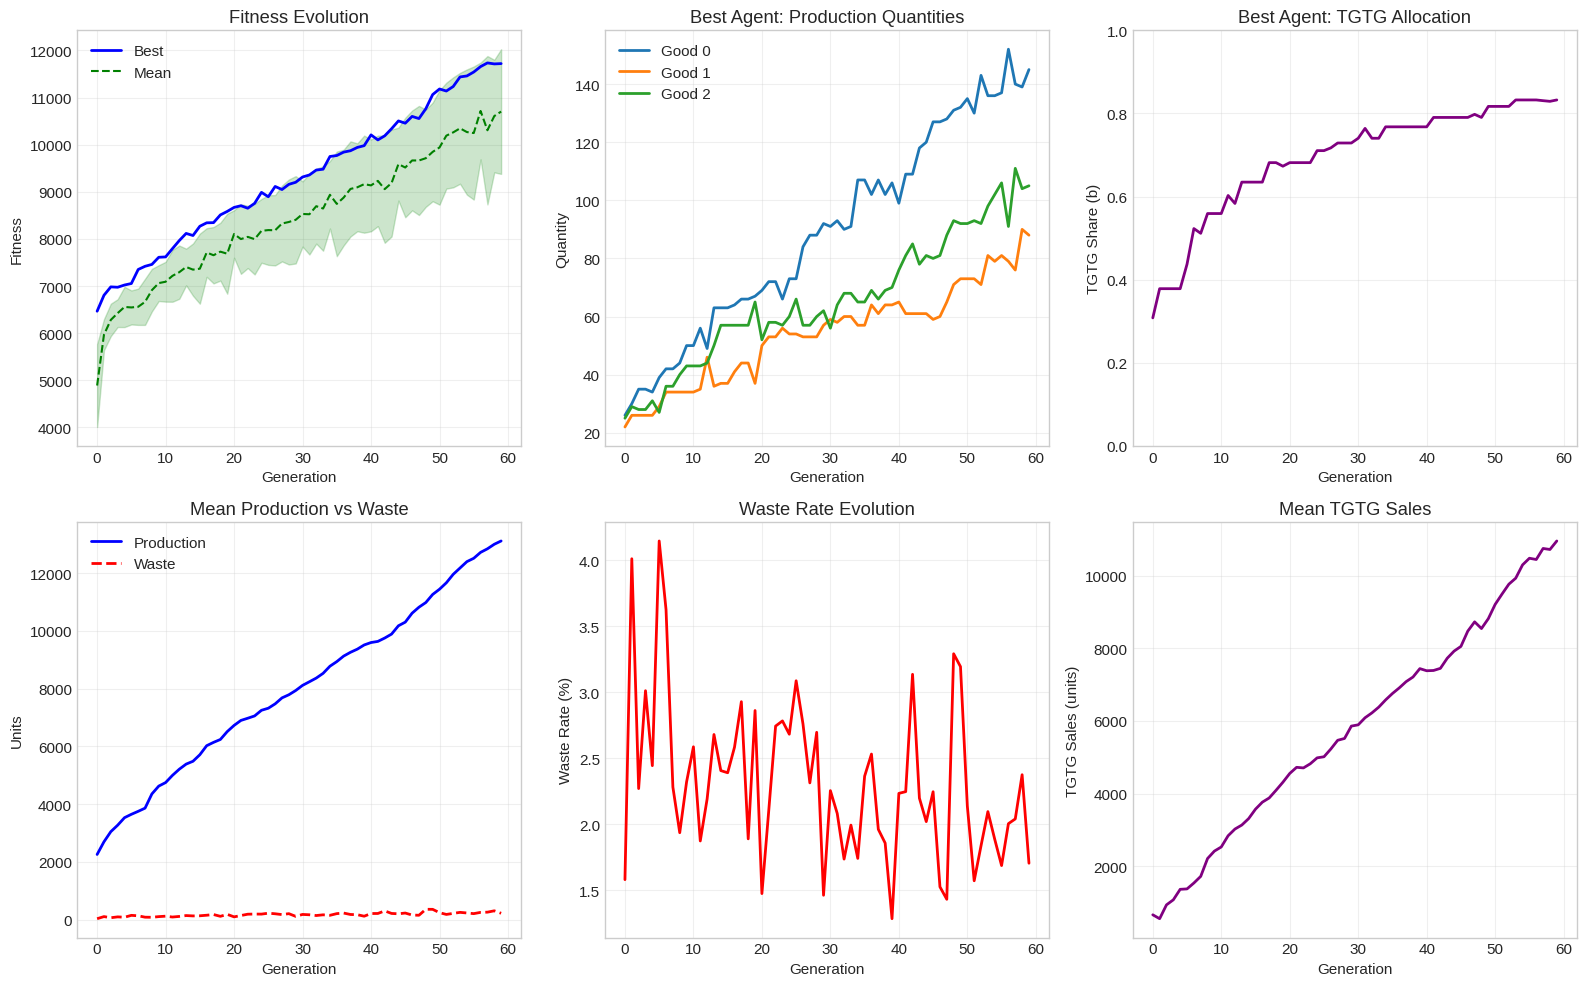

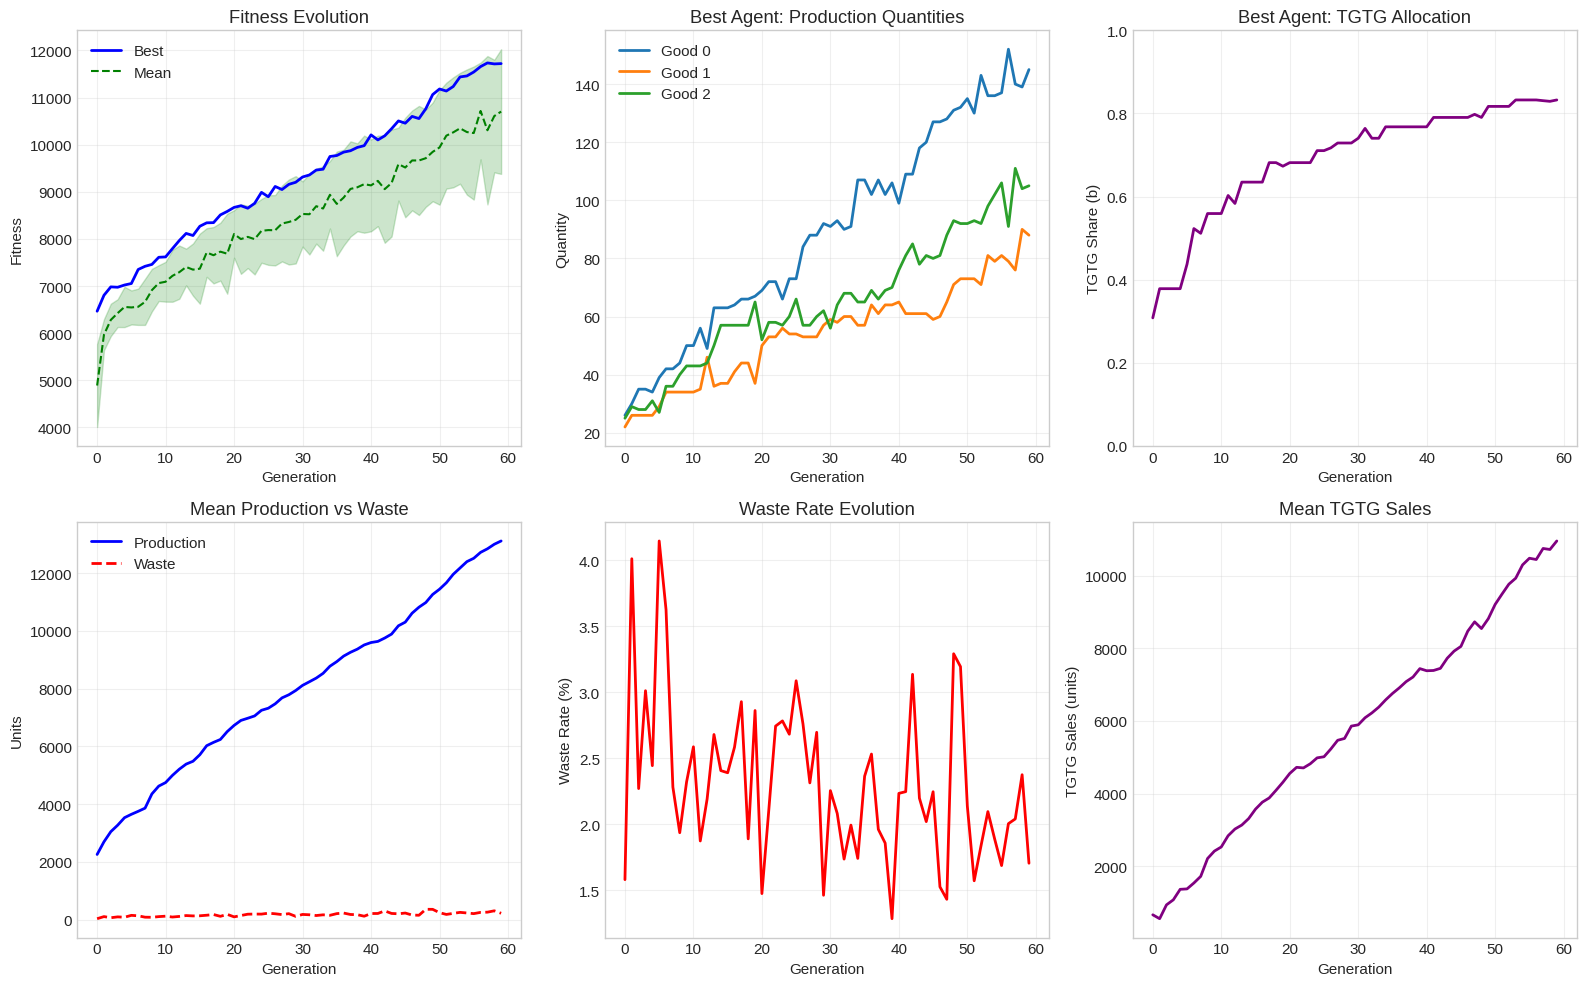

In [44]:
# Plot training progress for the risk-averse case (γ = 1.0)
selected_gamma = 1.0
print(f"Training progress for γ = {selected_gamma} (Risk-averse agent)")
print("-" * 50)

trainer = experiment_results[selected_gamma]['trainer']
trainer.plot_training_progress()

### 7.3 Comparative Analysis
Comparing results across different risk aversion levels.

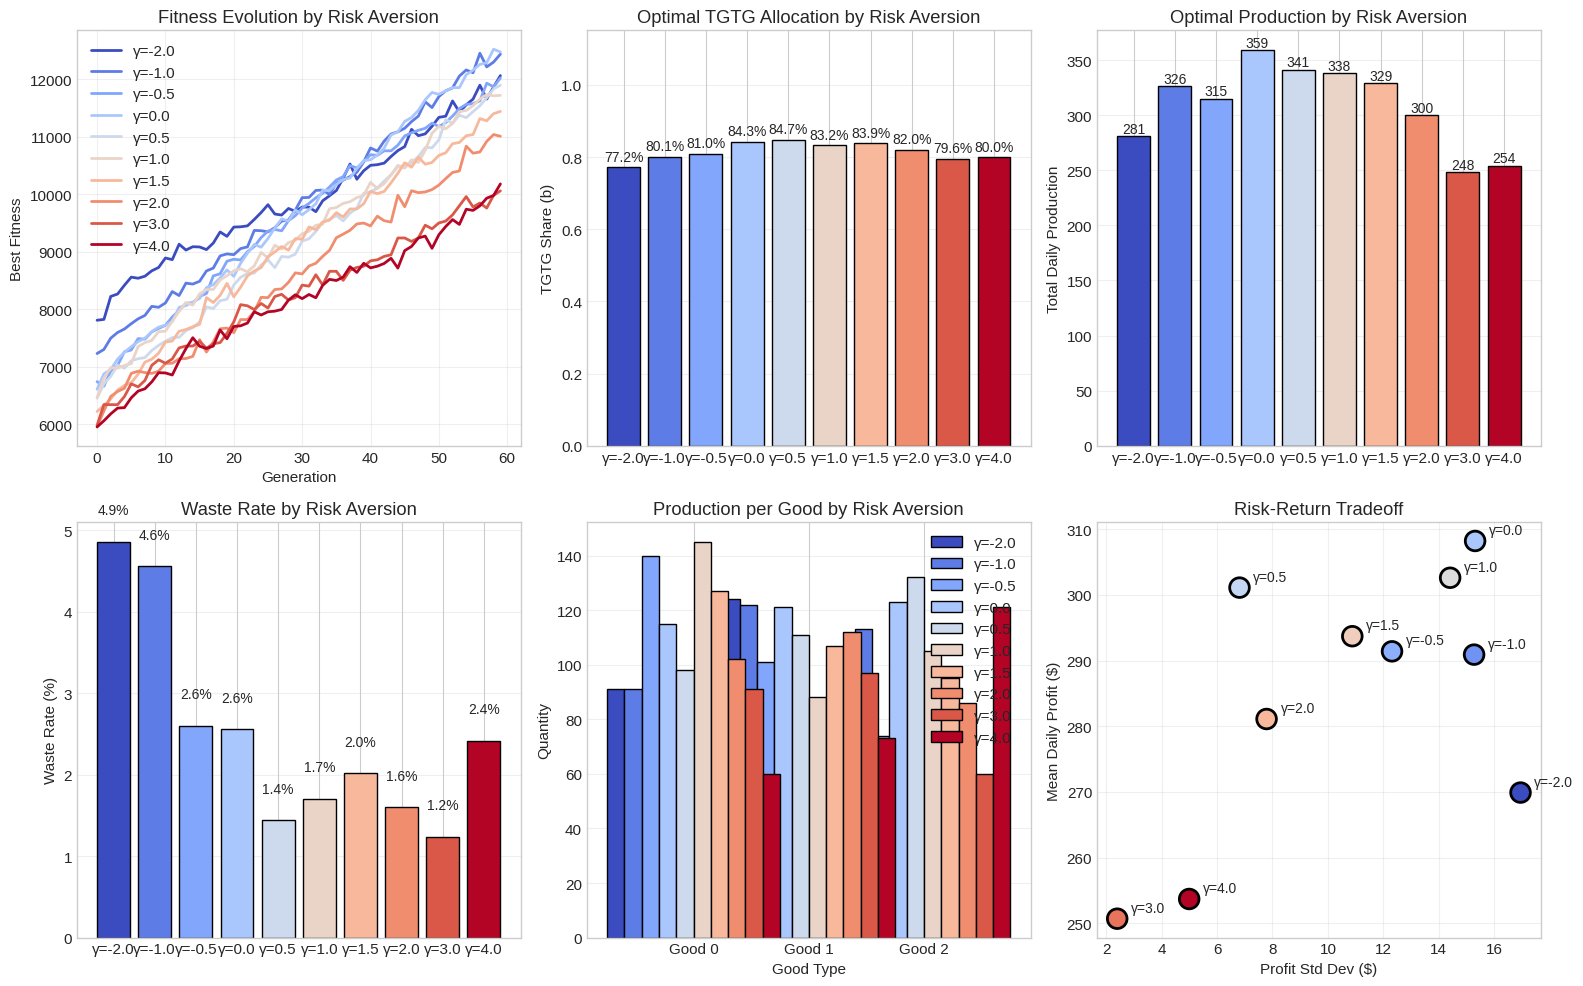


KEY OBSERVATION: TGTG Share vs Risk Aversion
γ = -2.0 (Risk-seeking): TGTG Share = 77.2%
γ = -1.0 (Risk-seeking): TGTG Share = 80.1%
γ = -0.5 (Risk-seeking): TGTG Share = 81.0%
γ = +0.0 (Risk-neutral): TGTG Share = 84.3%
γ = +0.5 (Risk-averse): TGTG Share = 84.7%
γ = +1.0 (Risk-averse): TGTG Share = 83.2%
γ = +1.5 (Risk-averse): TGTG Share = 83.9%
γ = +2.0 (Risk-averse): TGTG Share = 82.0%
γ = +3.0 (Risk-averse): TGTG Share = 79.6%
γ = +4.0 (Risk-averse): TGTG Share = 80.0%


In [45]:
# Comparative analysis across gamma values
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

gammas = list(experiment_results.keys())
colors = plt.cm.coolwarm(np.linspace(0, 1, len(gammas)))

# 1. Fitness evolution comparison
ax = axes[0, 0]
for gamma, color in zip(gammas, colors):
    history = experiment_results[gamma]['history']
    gens = [s.generation for s in history]
    fitness = [s.best_fitness for s in history]
    ax.plot(gens, fitness, color=color, linewidth=2, label=f'γ={gamma}')
ax.set_xlabel('Generation')
ax.set_ylabel('Best Fitness')
ax.set_title('Fitness Evolution by Risk Aversion')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Final TGTG share by gamma
ax = axes[0, 1]
final_b = [experiment_results[g]['best_agent'].b for g in gammas]
bars = ax.bar(range(len(gammas)), final_b, color=colors, edgecolor='black')
ax.set_xticks(range(len(gammas)))
ax.set_xticklabels([f'γ={g}' for g in gammas])
ax.set_ylabel('TGTG Share (b)')
ax.set_title('Optimal TGTG Allocation by Risk Aversion')
ax.set_ylim(0, max(final_b) * 1.3 + 0.05)
for bar, b in zip(bars, final_b):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{b:.1%}', ha='center', va='bottom', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

# 3. Total production by gamma
ax = axes[0, 2]
productions = [np.sum(experiment_results[g]['best_agent'].q) for g in gammas]
bars = ax.bar(range(len(gammas)), productions, color=colors, edgecolor='black')
ax.set_xticks(range(len(gammas)))
ax.set_xticklabels([f'γ={g}' for g in gammas])
ax.set_ylabel('Total Daily Production')
ax.set_title('Optimal Production by Risk Aversion')
for bar, p in zip(bars, productions):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
            str(p), ha='center', va='bottom', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

# 4. Waste rate by gamma
ax = axes[1, 0]
waste_rates = [experiment_results[g]['final_stats'].mean_waste / 
               experiment_results[g]['final_stats'].mean_production * 100 
               for g in gammas]
bars = ax.bar(range(len(gammas)), waste_rates, color=colors, edgecolor='black')
ax.set_xticks(range(len(gammas)))
ax.set_xticklabels([f'γ={g}' for g in gammas])
ax.set_ylabel('Waste Rate (%)')
ax.set_title('Waste Rate by Risk Aversion')
for bar, w in zip(bars, waste_rates):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, 
            f'{w:.1f}%', ha='center', va='bottom', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

# 5. Production per good comparison
ax = axes[1, 1]
x = np.arange(env_config.L)
width = 0.15
for i, (gamma, color) in enumerate(zip(gammas, colors)):
    q = experiment_results[gamma]['best_agent'].q
    ax.bar(x + i*width, q, width, color=color, label=f'γ={gamma}', edgecolor='black')
ax.set_xlabel('Good Type')
ax.set_ylabel('Quantity')
ax.set_title('Production per Good by Risk Aversion')
ax.set_xticks(x + width * (len(gammas)-1) / 2)
ax.set_xticklabels([f'Good {i}' for i in range(env_config.L)])
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3, axis='y')

# 6. Mean profit vs Profit Std (Risk-Return tradeoff)
ax = axes[1, 2]
mean_profits = []
std_profits = []
for gamma in gammas:
    agent = experiment_results[gamma]['best_agent']
    trainer = experiment_results[gamma]['trainer']
    epoch = simulate_epoch(agent, trainer.consumers, env_config, evo_config.D)
    mean_profits.append(epoch.mean_profit)
    std_profits.append(epoch.profit_std)

# Scatter plot with gamma as color
scatter = ax.scatter(std_profits, mean_profits, c=gammas, cmap='coolwarm', 
                     s=200, edgecolors='black', linewidth=2)
for i, gamma in enumerate(gammas):
    ax.annotate(f'γ={gamma}', (std_profits[i], mean_profits[i]), 
                textcoords="offset points", xytext=(10, 5), fontsize=10)
ax.set_xlabel('Profit Std Dev ($)')
ax.set_ylabel('Mean Daily Profit ($)')
ax.set_title('Risk-Return Tradeoff')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "=" * 70)
print("KEY OBSERVATION: TGTG Share vs Risk Aversion")
print("=" * 70)
for gamma, b in zip(gammas, final_b):
    risk_type = "Risk-seeking" if gamma < 0 else "Risk-neutral" if gamma == 0 else "Risk-averse"
    print(f"γ = {gamma:+.1f} ({risk_type}): TGTG Share = {b:.1%}")

### 7.4 Baseline Comparison: With vs Without TGTG
Compare the evolved agent against a baseline that doesn't use the TGTG option (b=0).

BASELINE COMPARISON: With TGTG vs Without TGTG

   γ TGTG Share Evolved Profit Baseline Profit Profit Δ Evolved Waste Baseline Waste Waste Δ
-2.0      77.2%         $10764          $-2196  +590.2%           339           8979  -96.2%
-1.0      80.1%         $11664          $-3996  +391.9%           339          10779  -96.9%
-0.5      81.0%         $11672          $-3556  +428.2%           157          10339  -98.5%
 0.0      84.3%         $12552          $-5316  +336.1%            82          12099  -99.3%
 0.5      84.7%         $12048          $-4596  +362.1%            18          11379  -99.8%
 1.0      83.2%         $12132          $-4476  +371.0%            82          11259  -99.3%
 1.5      83.9%         $11860          $-4116  +388.1%            30          10899  -99.7%
 2.0      82.0%         $11324          $-2956  +483.1%            44           9739  -99.5%
 3.0      79.6%         $10040           $-876 +1246.1%             5           7659  -99.9%
 4.0      80.0%       

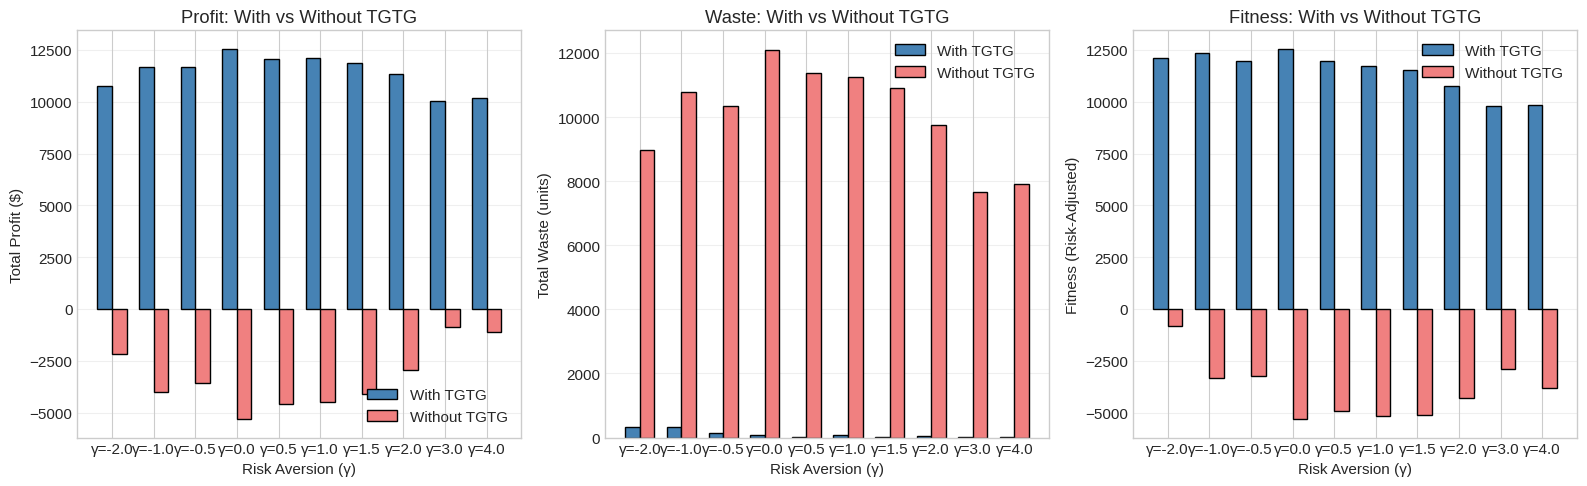

In [46]:
# Create baseline agents (no TGTG: b=0) with same production as evolved agents
print("BASELINE COMPARISON: With TGTG vs Without TGTG")
print("=" * 70)

baseline_results = {}

# For each gamma, create baseline with same production but b=0
for gamma in gammas:
    evolved_agent = experiment_results[gamma]['best_agent']
    
    # Baseline: same production, no TGTG
    baseline_agent = BakerAgent(
        q=evolved_agent.q.copy(),
        b=0.0,  # No TGTG
        gamma=gamma
    )
    
    # Create consumer population (use same seed for fair comparison)
    np.random.seed(42)
    consumers = ConsumerPopulation(N=env_config.N, L=env_config.L, preference_mode="correlated")
    
    # Evaluate baseline
    baseline_epoch = simulate_epoch(baseline_agent, consumers, env_config, evo_config.D)
    baseline_agent.fitness = baseline_epoch.fitness
    
    # Evaluate evolved with same consumers
    np.random.seed(42)
    consumers = ConsumerPopulation(N=env_config.N, L=env_config.L, preference_mode="correlated")
    evolved_epoch = simulate_epoch(evolved_agent, consumers, env_config, evo_config.D)
    
    baseline_results[gamma] = {
        'evolved': evolved_epoch,
        'baseline': baseline_epoch,
        'evolved_agent': evolved_agent,
        'baseline_agent': baseline_agent
    }

# Create comparison table
comparison_data = []
for gamma in gammas:
    res = baseline_results[gamma]
    evolved = res['evolved']
    baseline = res['baseline']
    evolved_agent = res['evolved_agent']
    
    comparison_data.append({
        'γ': gamma,
        'TGTG Share': f"{evolved_agent.b:.1%}",
        'Evolved Profit': f"${evolved.total_profit:.0f}",
        'Baseline Profit': f"${baseline.total_profit:.0f}",
        'Profit Δ': f"{((evolved.total_profit - baseline.total_profit) / abs(baseline.total_profit) * 100):+.1f}%",
        'Evolved Waste': f"{evolved.total_waste:.0f}",
        'Baseline Waste': f"{baseline.total_waste:.0f}",
        'Waste Δ': f"{((evolved.total_waste - baseline.total_waste) / max(1, baseline.total_waste) * 100):+.1f}%"
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n" + comparison_df.to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Profit comparison
ax = axes[0]
x = np.arange(len(gammas))
width = 0.35
evolved_profits = [baseline_results[g]['evolved'].total_profit for g in gammas]
baseline_profits = [baseline_results[g]['baseline'].total_profit for g in gammas]
bars1 = ax.bar(x - width/2, evolved_profits, width, label='With TGTG', color='steelblue', edgecolor='black')
bars2 = ax.bar(x + width/2, baseline_profits, width, label='Without TGTG', color='lightcoral', edgecolor='black')
ax.set_xlabel('Risk Aversion (γ)')
ax.set_ylabel('Total Profit ($)')
ax.set_title('Profit: With vs Without TGTG')
ax.set_xticks(x)
ax.set_xticklabels([f'γ={g}' for g in gammas])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# 2. Waste comparison
ax = axes[1]
evolved_waste = [baseline_results[g]['evolved'].total_waste for g in gammas]
baseline_waste = [baseline_results[g]['baseline'].total_waste for g in gammas]
bars1 = ax.bar(x - width/2, evolved_waste, width, label='With TGTG', color='steelblue', edgecolor='black')
bars2 = ax.bar(x + width/2, baseline_waste, width, label='Without TGTG', color='lightcoral', edgecolor='black')
ax.set_xlabel('Risk Aversion (γ)')
ax.set_ylabel('Total Waste (units)')
ax.set_title('Waste: With vs Without TGTG')
ax.set_xticks(x)
ax.set_xticklabels([f'γ={g}' for g in gammas])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# 3. Fitness comparison
ax = axes[2]
evolved_fitness = [baseline_results[g]['evolved'].fitness for g in gammas]
baseline_fitness = [baseline_results[g]['baseline'].fitness for g in gammas]
bars1 = ax.bar(x - width/2, evolved_fitness, width, label='With TGTG', color='steelblue', edgecolor='black')
bars2 = ax.bar(x + width/2, baseline_fitness, width, label='Without TGTG', color='lightcoral', edgecolor='black')
ax.set_xlabel('Risk Aversion (γ)')
ax.set_ylabel('Fitness (Risk-Adjusted)')
ax.set_title('Fitness: With vs Without TGTG')
ax.set_xticks(x)
ax.set_xticklabels([f'γ={g}' for g in gammas])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### 7.5 Sensitivity Analysis: Walk-out Probability
How does the optimal strategy change when consumers are more or less patient?

SENSITIVITY ANALYSIS: Walk-out Probability (r)
Fixed γ = 1.0 (risk-averse)
Testing r values: [0.1, 0.3, 0.5, 0.7]


Training with r = 0.1... Done! b=79.5%, production=248

Training with r = 0.3... Done! b=79.8%, production=264

Training with r = 0.5... Done! b=76.1%, production=231

Training with r = 0.7... Done! b=76.4%, production=230


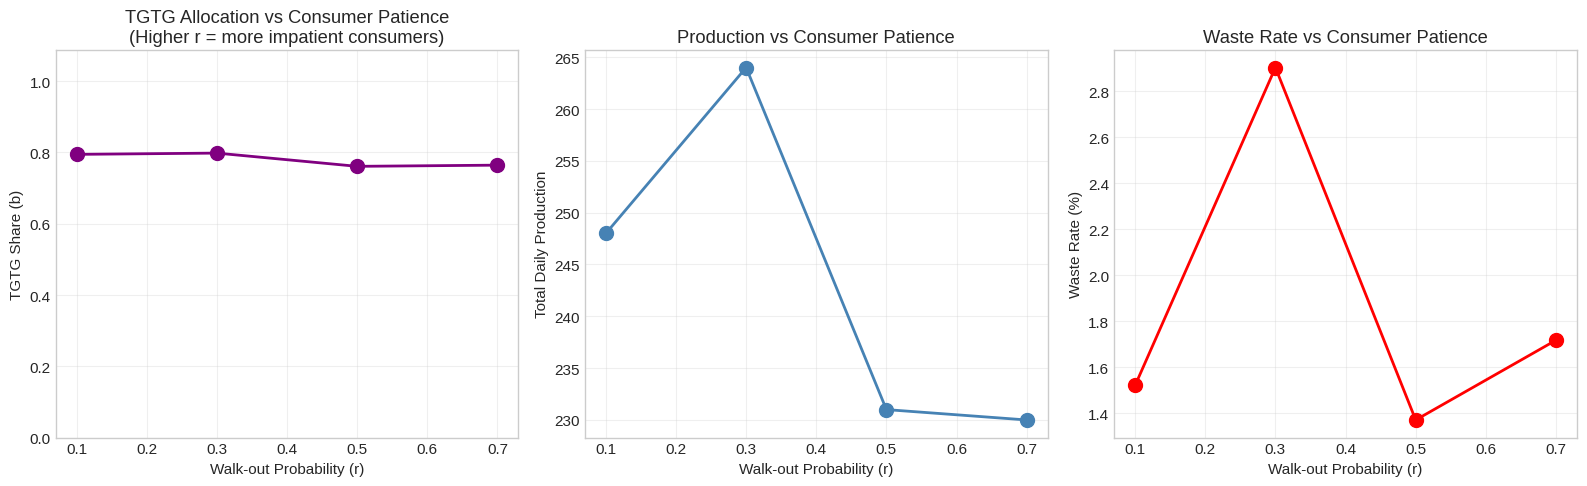


SENSITIVITY ANALYSIS SUMMARY
Walk-out (r) TGTG Share  Production Waste Rate Fitness
         0.1      79.5%         248       1.5%    7545
         0.3      79.8%         264       2.9%    7891
         0.5      76.1%         231       1.4%    7215
         0.7      76.4%         230       1.7%    7209


In [47]:
# Sensitivity analysis: vary walk-out probability
R_VALUES = [0.1, 0.3, 0.5, 0.7]
FIXED_GAMMA = 1.0  # Use moderate risk aversion

sensitivity_results = {}

# Reduce generations for faster sensitivity analysis
quick_evo_config = EvolutionConfig(
    mu=0.4,
    sigma_q=4.0,
    sigma_b=0.08,
    D=30,
    E=40,  # Fewer generations
    population_size=60,  # Smaller population
    elite_fraction=0.1
)

print("SENSITIVITY ANALYSIS: Walk-out Probability (r)")
print("=" * 70)
print(f"Fixed γ = {FIXED_GAMMA} (risk-averse)")
print(f"Testing r values: {R_VALUES}")
print()

for r in R_VALUES:
    print(f"\nTraining with r = {r}...", end=" ")
    
    np.random.seed(100 + int(r * 100))
    
    # Create custom environment with this r
    custom_env = EnvironmentConfig(
        N=env_config.N,
        L=env_config.L,
        r=r,  # Vary this
        chi=env_config.chi,
        rho=env_config.rho,
        tau=env_config.tau,
        alpha=env_config.alpha
    )
    
    trainer = EvolutionaryTrainer(
        env_config=custom_env,
        evo_config=quick_evo_config,
        gamma=FIXED_GAMMA,
        preference_mode="correlated"
    )
    
    history = trainer.train(verbose=False)
    best_agent = trainer.get_best_agent()
    
    sensitivity_results[r] = {
        'agent': best_agent,
        'history': history,
        'final_stats': history[-1],
        'trainer': trainer
    }
    
    print(f"Done! b={best_agent.b:.1%}, production={np.sum(best_agent.q)}")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

r_values = list(sensitivity_results.keys())
colors = plt.cm.plasma(np.linspace(0.2, 0.8, len(r_values)))

# 1. TGTG share vs walk-out probability
ax = axes[0]
b_values = [sensitivity_results[r]['agent'].b for r in r_values]
ax.plot(r_values, b_values, 'o-', color='purple', linewidth=2, markersize=10)
ax.set_xlabel('Walk-out Probability (r)')
ax.set_ylabel('TGTG Share (b)')
ax.set_title('TGTG Allocation vs Consumer Patience\n(Higher r = more impatient consumers)')
ax.grid(True, alpha=0.3)
ax.set_ylim(0, max(b_values) * 1.3 + 0.05)

# 2. Total production vs walk-out probability
ax = axes[1]
productions = [np.sum(sensitivity_results[r]['agent'].q) for r in r_values]
ax.plot(r_values, productions, 'o-', color='steelblue', linewidth=2, markersize=10)
ax.set_xlabel('Walk-out Probability (r)')
ax.set_ylabel('Total Daily Production')
ax.set_title('Production vs Consumer Patience')
ax.grid(True, alpha=0.3)

# 3. Waste rate vs walk-out probability
ax = axes[2]
waste_rates = [sensitivity_results[r]['final_stats'].mean_waste / 
               sensitivity_results[r]['final_stats'].mean_production * 100 
               for r in r_values]
ax.plot(r_values, waste_rates, 'o-', color='red', linewidth=2, markersize=10)
ax.set_xlabel('Walk-out Probability (r)')
ax.set_ylabel('Waste Rate (%)')
ax.set_title('Waste Rate vs Consumer Patience')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary table
print("\n" + "=" * 70)
print("SENSITIVITY ANALYSIS SUMMARY")
print("=" * 70)
sens_data = []
for r in r_values:
    agent = sensitivity_results[r]['agent']
    stats = sensitivity_results[r]['final_stats']
    sens_data.append({
        'Walk-out (r)': f"{r:.1f}",
        'TGTG Share': f"{agent.b:.1%}",
        'Production': np.sum(agent.q),
        'Waste Rate': f"{stats.mean_waste/stats.mean_production*100:.1f}%",
        'Fitness': f"{agent.fitness:.0f}"
    })
sens_df = pd.DataFrame(sens_data)
print(sens_df.to_string(index=False))

### 7.6 Key Findings Summary

KEY FINDINGS FROM THE SIMULATION

1. TGTG ADOPTION:
   • Average TGTG share across all γ: 81.6%
   • Range: 77.2% (γ=-2.0) to 84.7% (γ=0.5)

2. RISK AVERSION EFFECT:
   • Correlation between γ and TGTG share: 0.13
   • No strong relationship detected (may need more generations)

3. WASTE REDUCTION:
   • Average waste reduction with TGTG: +98.9%
   • ✓ TGTG effectively reduces food waste!

4. PROFIT IMPACT:
   • Average profit change with TGTG: +560.7%

5. CONSUMER PATIENCE (Walk-out probability):
   • Correlation between r and TGTG share: -0.84
   • When consumers are patient, less need for TGTG guarantee

SIMULATION COMPLETE


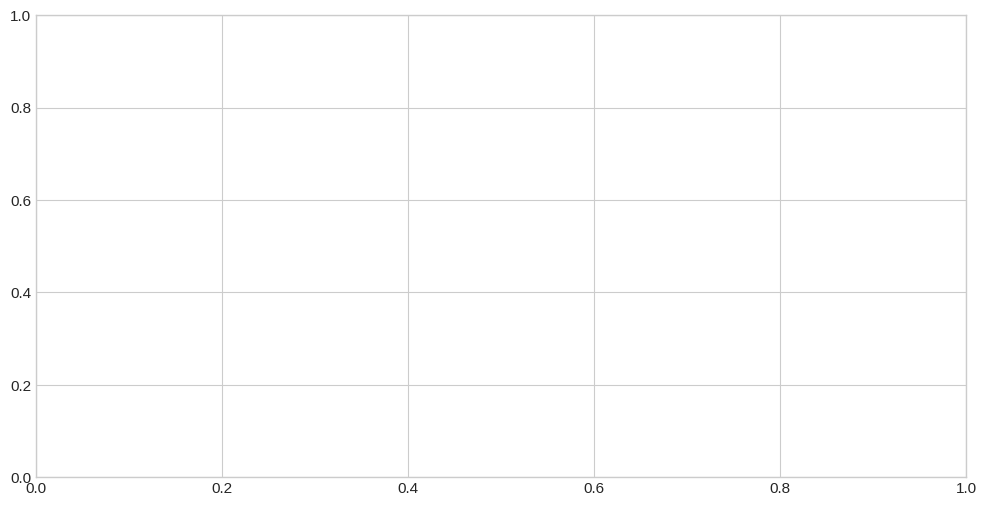

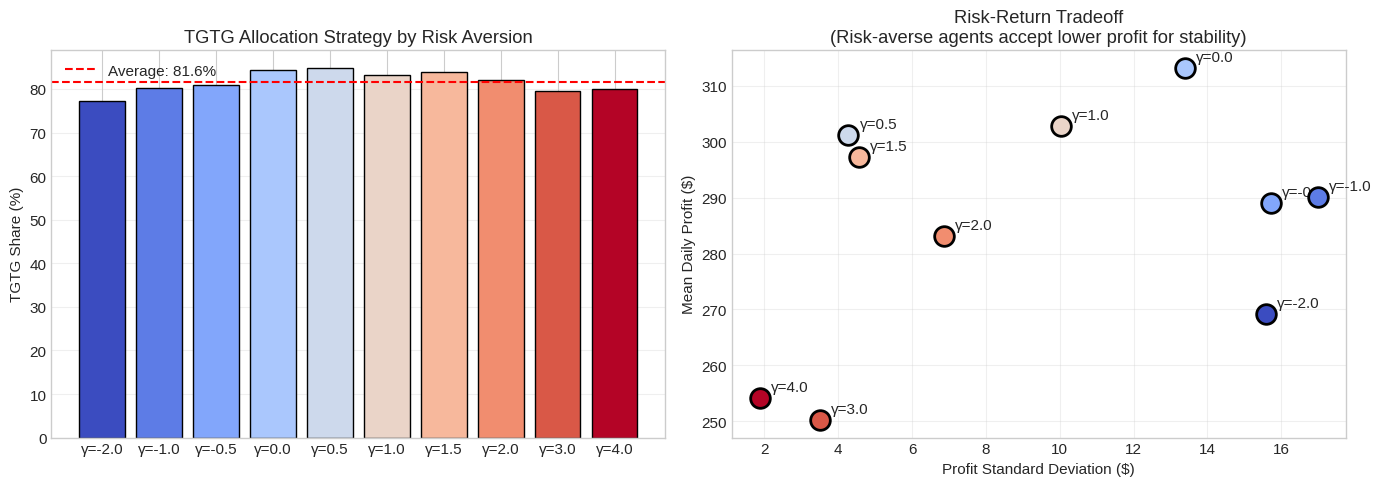

In [48]:
# Generate key findings based on the experiment results
print("=" * 70)
print("KEY FINDINGS FROM THE SIMULATION")
print("=" * 70)

gammas = list(experiment_results.keys())

# 1. TGTG adoption pattern
b_values = [experiment_results[g]['best_agent'].b for g in gammas]
avg_b = np.mean(b_values)
print(f"\n1. TGTG ADOPTION:")
print(f"   • Average TGTG share across all γ: {avg_b:.1%}")
print(f"   • Range: {min(b_values):.1%} (γ={gammas[np.argmin(b_values)]}) to {max(b_values):.1%} (γ={gammas[np.argmax(b_values)]})")

# 2. Risk aversion effect - check correlation
correlation = np.corrcoef(gammas, b_values)[0, 1]
print(f"\n2. RISK AVERSION EFFECT:")
print(f"   • Correlation between γ and TGTG share: {correlation:.2f}")
if correlation > 0.3:
    print(f"   • ✓ More risk-averse agents (higher γ) use MORE TGTG")
    print(f"   • TGTG provides guaranteed sales, reducing profit variance")
elif correlation < -0.3:
    print(f"   • Risk-seeking agents prefer higher variance strategies")
else:
    print(f"   • No strong relationship detected (may need more generations)")

# 3. Waste reduction
evolved_waste = [baseline_results[g]['evolved'].total_waste for g in gammas]
baseline_waste = [baseline_results[g]['baseline'].total_waste for g in gammas]
waste_reduction = [(b - e) / max(1, b) * 100 for e, b in zip(evolved_waste, baseline_waste)]
avg_waste_reduction = np.mean(waste_reduction)
print(f"\n3. WASTE REDUCTION:")
print(f"   • Average waste reduction with TGTG: {avg_waste_reduction:+.1f}%")
if avg_waste_reduction > 5:
    print(f"   • ✓ TGTG effectively reduces food waste!")
elif avg_waste_reduction < -5:
    print(f"   • TGTG may encourage overproduction in some cases")
else:
    print(f"   • Minimal effect on waste (similar levels)")

# 4. Profit impact
evolved_profit = [baseline_results[g]['evolved'].total_profit for g in gammas]
baseline_profit = [baseline_results[g]['baseline'].total_profit for g in gammas]
profit_change = [(e - b) / abs(b) * 100 if b != 0 else 0 for e, b in zip(evolved_profit, baseline_profit)]
avg_profit_change = np.mean(profit_change)
print(f"\n4. PROFIT IMPACT:")
print(f"   • Average profit change with TGTG: {avg_profit_change:+.1f}%")
if avg_profit_change < 0:
    print(f"   • Lower profit expected (TGTG sells at lower price)")
    print(f"   • But provides stability valued by risk-averse agents")

# 5. Consumer patience sensitivity
r_values = list(sensitivity_results.keys())
sens_b = [sensitivity_results[r]['agent'].b for r in r_values]
corr_r_b = np.corrcoef(r_values, sens_b)[0, 1]
print(f"\n5. CONSUMER PATIENCE (Walk-out probability):")
print(f"   • Correlation between r and TGTG share: {corr_r_b:.2f}")
if corr_r_b > 0.3:
    print(f"   • ✓ When consumers are impatient (high r), bakers use MORE TGTG")
    print(f"   • This hedges against lost sales from walk-outs")
elif corr_r_b < -0.3:
    print(f"   • When consumers are patient, less need for TGTG guarantee")

print("\n" + "=" * 70)
print("SIMULATION COMPLETE")
print("=" * 70)

# Final visualization: summary heatmap
fig, ax = plt.subplots(figsize=(12, 6))

metrics = ['TGTG Share (%)', 'Production', 'Waste Rate (%)', 'Fitness/100']
data = np.zeros((len(gammas), len(metrics)))

for i, g in enumerate(gammas):
    agent = experiment_results[g]['best_agent']
    stats = experiment_results[g]['final_stats']
    data[i, 0] = agent.b * 100  # TGTG share as percentage
    data[i, 1] = np.sum(agent.q)  # Total production
    data[i, 2] = stats.mean_waste / stats.mean_production * 100  # Waste rate
    data[i, 3] = agent.fitness / 100  # Scaled fitness

# Create bar chart comparison
x = np.arange(len(gammas))
width = 0.2

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: TGTG share by gamma
ax = axes[0]
bars = ax.bar(x, [experiment_results[g]['best_agent'].b * 100 for g in gammas], 
              color=plt.cm.coolwarm(np.linspace(0, 1, len(gammas))), edgecolor='black')
ax.set_xticks(x)
ax.set_xticklabels([f'γ={g}' for g in gammas])
ax.set_ylabel('TGTG Share (%)')
ax.set_title('TGTG Allocation Strategy by Risk Aversion')
ax.axhline(y=avg_b * 100, color='red', linestyle='--', label=f'Average: {avg_b:.1%}')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Right: Profit vs Std scatter
ax = axes[1]
mean_profits = []
std_profits = []
for gamma in gammas:
    agent = experiment_results[gamma]['best_agent']
    trainer = experiment_results[gamma]['trainer']
    epoch = simulate_epoch(agent, trainer.consumers, env_config, evo_config.D)
    mean_profits.append(epoch.mean_profit)
    std_profits.append(epoch.profit_std)

colors_scatter = plt.cm.coolwarm(np.linspace(0, 1, len(gammas)))
for i, (mp, sp, g) in enumerate(zip(mean_profits, std_profits, gammas)):
    ax.scatter(sp, mp, c=[colors_scatter[i]], s=200, edgecolors='black', linewidth=2, zorder=5)
    ax.annotate(f'γ={g}', (sp, mp), textcoords="offset points", xytext=(8, 5), fontsize=11)

ax.set_xlabel('Profit Standard Deviation ($)')
ax.set_ylabel('Mean Daily Profit ($)')
ax.set_title('Risk-Return Tradeoff\n(Risk-averse agents accept lower profit for stability)')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 7.7 Comparative Analysis by Number of Goods (L)

Explore how the number of different goods affects the optimal TGTG strategy and outcomes.

In [ ]:
# =============================================================================
# COMPARATIVE ANALYSIS BY NUMBER OF GOODS (L)
# =============================================================================
# Test how the number of different goods affects TGTG strategy

L_VALUES = [1, 2, 3, 5, 8]  # Different diversification levels
SELECTED_GAMMAS = [-1.0, 0.0, 1.0, 2.0]  # Subset of gamma values for faster run

# Store results: {L: {gamma: results}}
L_experiment_results = {}

print("=" * 70)
print("COMPARATIVE ANALYSIS: EFFECT OF NUMBER OF GOODS (L)")
print("=" * 70)
print(f"\nL values to test: {L_VALUES}")
print(f"γ values: {SELECTED_GAMMAS}")
print()

# Reduced generations for this comparative analysis
quick_L_config = EvolutionConfig(
    population_size=30,
    E=25,  # Fewer generations
    D=50,
    elite_fraction=0.2,  # 20% elite
    mu=0.4,
    sigma_q=3,
    sigma_b=0.1
)

for L in L_VALUES:
    print(f"\n{'='*60}")
    print(f"Testing L = {L} goods")
    print(f"{'='*60}")
    
    # Create environment with this L
    L_env_config = EnvironmentConfig(
        N=env_config.N,
        L=L,
        r=env_config.r,
        chi=env_config.chi,
        rho=env_config.rho,
        tau=env_config.tau,
        alpha=env_config.alpha
    )
    
    L_experiment_results[L] = {}
    
    for gamma in SELECTED_GAMMAS:
        print(f"  γ = {gamma:+.1f} ", end="")
        
        np.random.seed(42 + L * 100 + int(gamma * 10))
        
        trainer = EvolutionaryTrainer(
            env_config=L_env_config,
            evo_config=quick_L_config,
            gamma=gamma,
            preference_mode="correlated"
        )
        
        history = trainer.train(verbose=False)
        best_agent = trainer.get_best_agent()
        final_epoch = simulate_epoch(best_agent, trainer.consumers, L_env_config, quick_L_config.D)
        
        L_experiment_results[L][gamma] = {
            'best_agent': best_agent,
            'final_stats': history[-1],
            'epoch': final_epoch
        }
        
        print(f"→ b={best_agent.b:.1%}, q_total={best_agent.total_production()}, "
              f"waste={final_epoch.total_waste/quick_L_config.D:.1f}/day")

print("\n" + "=" * 70)

# =============================================================================
# VISUALIZATION: L Comparative Results
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. TGTG Share by L and γ
ax = axes[0, 0]
width = 0.18
x = np.arange(len(L_VALUES))
for i, gamma in enumerate(SELECTED_GAMMAS):
    b_values = [L_experiment_results[L][gamma]['best_agent'].b * 100 for L in L_VALUES]
    ax.bar(x + i * width, b_values, width, label=f'γ={gamma}', 
           alpha=0.8, edgecolor='black')
ax.set_xlabel('Number of Goods (L)')
ax.set_ylabel('TGTG Share (%)')
ax.set_title('TGTG Allocation by Product Diversification')
ax.set_xticks(x + width * (len(SELECTED_GAMMAS) - 1) / 2)
ax.set_xticklabels([f'L={L}' for L in L_VALUES])
ax.legend(title='Risk Aversion')
ax.grid(True, alpha=0.3, axis='y')

# 2. Waste Rate by L and γ  
ax = axes[0, 1]
for i, gamma in enumerate(SELECTED_GAMMAS):
    waste_rates = []
    for L in L_VALUES:
        epoch = L_experiment_results[L][gamma]['epoch']
        waste_rate = epoch.total_waste / max(1, epoch.total_production) * 100
        waste_rates.append(waste_rate)
    ax.bar(x + i * width, waste_rates, width, label=f'γ={gamma}',
           alpha=0.8, edgecolor='black')
ax.set_xlabel('Number of Goods (L)')
ax.set_ylabel('Waste Rate (%)')
ax.set_title('Food Waste by Product Diversification')
ax.set_xticks(x + width * (len(SELECTED_GAMMAS) - 1) / 2)
ax.set_xticklabels([f'L={L}' for L in L_VALUES])
ax.legend(title='Risk Aversion')
ax.grid(True, alpha=0.3, axis='y')

# 3. Mean Daily Profit by L and γ
ax = axes[1, 0]
for i, gamma in enumerate(SELECTED_GAMMAS):
    profits = [L_experiment_results[L][gamma]['epoch'].mean_profit for L in L_VALUES]
    ax.bar(x + i * width, profits, width, label=f'γ={gamma}',
           alpha=0.8, edgecolor='black')
ax.set_xlabel('Number of Goods (L)')
ax.set_ylabel('Mean Daily Profit ($)')
ax.set_title('Profitability by Product Diversification')
ax.set_xticks(x + width * (len(SELECTED_GAMMAS) - 1) / 2)
ax.set_xticklabels([f'L={L}' for L in L_VALUES])
ax.legend(title='Risk Aversion')
ax.grid(True, alpha=0.3, axis='y')

# 4. Production Level by L
ax = axes[1, 1]
for i, gamma in enumerate(SELECTED_GAMMAS):
    productions = [L_experiment_results[L][gamma]['best_agent'].total_production() for L in L_VALUES]
    ax.plot(L_VALUES, productions, 'o-', linewidth=2, markersize=8, label=f'γ={gamma}')
expected_line = ax.axhline(y=env_config.expected_demand, color='red', linestyle='--', 
                           linewidth=2, label=f'Expected demand ({env_config.expected_demand:.0f})')
ax.set_xlabel('Number of Goods (L)')
ax.set_ylabel('Total Production (units)')
ax.set_title('Production Strategy by Diversification')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('L_comparative_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# =============================================================================
# Summary Table for L Analysis
# =============================================================================
print("\n" + "=" * 70)
print("SUMMARY: EFFECT OF NUMBER OF GOODS (L)")
print("=" * 70)

L_summary_data = []
for L in L_VALUES:
    for gamma in SELECTED_GAMMAS:
        agent = L_experiment_results[L][gamma]['best_agent']
        epoch = L_experiment_results[L][gamma]['epoch']
        waste_rate = epoch.total_waste / max(1, epoch.total_production) * 100
        L_summary_data.append({
            'L': L,
            'γ': gamma,
            'TGTG Share': f"{agent.b:.1%}",
            'Production': agent.total_production(),
            'Mean Profit': f"${epoch.mean_profit:.0f}",
            'Profit Std': f"${epoch.profit_std:.0f}",
            'Waste Rate': f"{waste_rate:.1f}%"
        })

L_summary_df = pd.DataFrame(L_summary_data)
print(L_summary_df.to_string(index=False))

# Key insight
print("\n" + "=" * 70)
print("KEY INSIGHTS ON DIVERSIFICATION (L)")
print("=" * 70)

# Check if more goods leads to different TGTG strategy
avg_b_by_L = {}
for L in L_VALUES:
    avg_b_by_L[L] = np.mean([L_experiment_results[L][g]['best_agent'].b for g in SELECTED_GAMMAS])

print(f"\nAverage TGTG share by L:")
for L, b in avg_b_by_L.items():
    print(f"  L={L}: {b:.1%}")

L_b_corr = np.corrcoef(L_VALUES, [avg_b_by_L[L] for L in L_VALUES])[0, 1]
print(f"\nCorrelation between L and TGTG share: {L_b_corr:.2f}")
if L_b_corr > 0.3:
    print("→ More product variety leads to HIGHER TGTG usage")
    print("  (More goods = more uncertainty in demand per good)")
elif L_b_corr < -0.3:
    print("→ More product variety leads to LOWER TGTG usage")
    print("  (Diversification itself provides risk hedging)")
else:
    print("→ No strong effect of product variety on TGTG strategy")

COMPARATIVE ANALYSIS: EFFECT OF NUMBER OF GOODS (L)

L values to test: [1, 2, 3, 5, 8]
γ values: [-1.0, 0.0, 1.0, 2.0]



TypeError: EvolutionConfig.__init__() got an unexpected keyword argument 'elite_size'

---

## 📊 Conclusions

This simulation demonstrates several key insights about the Too Good To Go mechanism:

### Main Findings

1. **TGTG adoption varies with risk preferences**: 
   - More risk-averse bakers (higher γ) tend to allocate a larger share of production to TGTG bags
   - TGTG provides **guaranteed revenue** at lower price, reducing profit variance
   - Risk-seeking agents prefer the variance of regular sales

2. **Economic trade-offs**:
   - Regular sale margin: ρ - χ (higher profit per unit)
   - TGTG margin: τ - χ (lower but guaranteed)
   - Waste loss: -χ (complete loss)
   - TGTG is always better than waste when τ > 0

3. **Consumer behavior matters**: 
   - Higher walk-out probability (impatient consumers) → more TGTG adoption
   - TGTG hedges against demand uncertainty

4. **Waste reduction**:
   - TGTG converts potential waste into guaranteed sales
   - The optimal strategy balances profit maximization with waste reduction

### Model Parameters Summary

| Parameter | Value | Interpretation |
|-----------|-------|----------------|
| ρ (sale price) | $5.00 | Revenue from regular sale |
| τ (TGTG price) | $2.50 | Revenue from TGTG (guaranteed) |
| χ (cost) | $2.00 | Production cost per unit |
| Regular margin | $3.00 | Profit per regular sale |
| TGTG margin | $0.50 | Profit per TGTG sale |

---

### Future Extensions

- Add multiple competing bakers (market dynamics)
- Model dynamic pricing strategies
- Include consumer learning and preference updates
- Add seasonal demand variations
- Implement crossover in the evolutionary algorithm
- Study optimal τ pricing from platform perspective